In [1]:
%pylab inline
import pandas as pd

import numpy as np
from __future__ import division
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import logging
logger = logging.getLogger()

Populating the interactive namespace from numpy and matplotlib


4 Mining Data Streams
============

Data:    
1. database   
2. stream:     
    + lost forever if the data arrived is not processed immediately or stored.    
    + the data arrives so rapidly that it isn't feasible to store all.   
    
    solution: summarization     
        + sample/filter, then estimate     
        + fixed-length "window"

### 4.1 The Stream Data Model

Examples of Steam Sources:   

+ Sensor Data:      
  Deploy a million sensors    
  
+ Image Data:     
  satellites, surveilance camera

+ Internet and Web Traffic

![Fig 4.1: A data-stream_management system](files/res/figure_4_1.png)

##### 4.1.3 Stream Queries
two ways:

1. standing queries     
   preset, permanetly execting, and produce outputs at appropriate times.    

2. ad-hoc queries    
   a question asked once about the current state of a steam or streams.    
   + a common sample approach is to store a **sliding windows** of each stream in the working store.
  
  
**generalizations** about stream algorithms:

1. Often, an **approximate answer** is much more **efficient** than an **exact solution**.

2. **hash function** introduces useful **randomness** intho the algorithm's behavior $\to$ approximate answer

### 4.2 Sampling Data in a Stream

extract reliable samples from a stream:    
select $S \subset B$, $\, s.t. \, E[f(S)] = E[f(B)]$.

Example   
Prob: What fraction of the typical user's queries were repeated over the past month?     

given: a user has issued $s$ search queries one time, $d$ queries two times, and no queires more than twice.

solutions:

- _REAL_: $$tf = \frac{d}{s+d}$$

- _BAD_: store 1/10 th of the stream **elements**.    
  + for s: $1/10 s$ one time    
  + for d:      
    $(1/10)*(1/10)*d = 1/100 d$ two times,      
    $1/10*9/10 + 9/10*1/10 d = 18/100d$ one time.
  + calc: 
  $$\hat{tf} = \frac{1/100d}{1/10s + 1/100d + 18/100d} = \frac{d}{10s + 19d}$$

- _GOOD_: pick 1/10th of the **users** and take all their searches for the sample.    
  $$\hat{tf} = \frac{d}{s+d}$$     
  
  sample: **hash**    
  obtain a sample consisting of any rational fraction $a/b$ of the users by hashing user names to $b$ buckets. Add the search query to the sample if the hash value is less than $a$.
  
  **The General Sampling Problem**   
  Our steam $x$ consists of tuples with $n$ components $\{x_n\}$(eg: user, query, time), and a subset of the components are the _key_ components $x_k$(eg: user).     
  To take a sample of size $a/b$, we hash the _key_ value $h(x_k)$ for each tuple to $b$ buckets, and accept the tuple if $h(x_k) < a$.
  
  **varying the sample size**    
  storage is limited, while users/queries grows as time goes on  ==> decrease the select fraction $a/b$.    
  
  solution:   
  1. $h(x) = \{0, 1, \dots, B-1\}$, $B$ is sufficient large.    
  2. maintain a threshold $t$, we accept when $h(x) < t$.       
  3. $t = t - 1$ if the allotted space is exceeded. remove all samples $h(x) = t$.    
     [opt] efficient:   
     + lower $t$ by more than 1.    
     + maintaining an index on the hash value to find all those tuples quickly.

### 4.3 Filtering Streams

#### 4.3.2 The Bloom Filter

##### component
0. key values: $ S = \{s_1, s_2, \dotsm, s_m\}$. 

1. array $B$ of $n$ bits, initially all 0's.

2. $h_i(s_j) \in [1, n], \quad i = 1, 2, \dotsm, k$.

##### intialization
1. $B$ are all 0's.

2. $B[h_i(s_j)] = 1$ for every hash function and every key value.

##### test
to test a key $K$:    
if $ALL_{i=1}^{k} (h_i(K)) = 1$, then allow it, $K \in S$;  else reject it.

##### Analysis
we have $n$ targets, $k \times m$ darts.

1. a given dart will NOT hit a given target: $$ P = (n - 1) / n $$

2. all darts will NOT hit a given target: 
   \begin{align}
        P &= (\frac{n-1}{n})^{k m} \\
          &= (1 - \frac{1}{n})^{n \frac{1}{n} k m} \\
          &\approx e^{-\frac{k m}{n}}
   \end{align}
   namely, the possibility of a bit remained 0 is $e^{-\frac{k m}{n}}$. 

3. the possibility of a bit remained 1 is $1 - e^{-\frac{k m}{n}}$.

4. for a key $K$, the possibility of all of bits of $h_i(K)$ remained 1 is: $$ (1 - e^{-\frac{k m}{n}})^{k} $$

conclusion:    
P[false negtive] = 0, P[false positive] = $ (1 - e^{-\frac{k m}{n}})^{k} $.

### 4.4 Counting Distinct Elements in a Stream
Solution:

1. keep a list of all the elements seens so far in main memeory. $\gets$ the number of distinct elements is not too great.

2. use more machines.

3. the Flajolet-Martin algorithm.


#### 4.4.2 the Flajolet-Martin Algorithm
**tail length** for $a$ and $h$:     
the number of 0's at the end of the bit string $h(a)$,      
where $a$ is a stream element, and $h$ is a hash function which maps the elements of an universal set to a bit-string that is sufficiently long. 

**estimate**:     
We use estimate $2^R$ for the number of distinct elements seen in the stream,   
where $R$ is the maximum tail length of any $a$ seen so far in the stream.

**original idea**:    
$\text{different elements }\uparrow \implies \text{ different bit-string } h(a) \uparrow \implies \text{ "unusual" value occurs } \implies $ use unusual properity to estimate.  

##### Analysis
1. for a given $a$, the probility of $h(a)$ ending in at least $r$ 0's is: $(\frac{1}{2})^r$.

2. for $m$ distinct elements, the probility of none of them ending in at least $r$ 0's is: 
   \begin{align}
       \neg P &= (1 - (\frac{1}{2})^r)^m \\
         &= (1 - 2^{-r})^{2^r 2^{-r} m} \\
         &\approx e^{-\frac{m}{2^r}}
   \end{align}

3. the probility of at least one of them ending in at least $r$ 0's is: $P = 1 - e^{-\frac{m}{2^r}}$

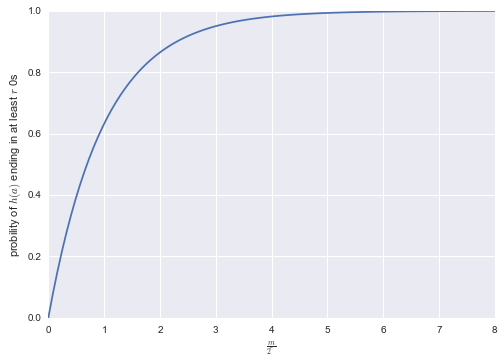

In [2]:
x = np.linspace(0, 8, 100)

p = 1 - np.exp(-x)

plt.plot(x, p)
plt.xlabel(r'$\frac{m}{2^r}$')
plt.ylabel(r'probility of $h(a)$ ending in at least $r$ 0s')

namely,    
\begin{equation}
    P \to \begin{cases}
        1 \quad \text{if } m \gg 2^r \\
        0 \quad \text{if } m \ll 2^r
    \end{cases}
\end{equation}
hence, $2^R$ is unlikely to be either much too high or much too low.


##### Combining Estimates
Suppose we have $k$ hash functions, then $k$ estimates $E_i$ of $m$ are obtained, but how to combine those estimates?

Solutions:

1. Average(E_i)   
   cons: overestimate $\Leftarrow$ if $E_p \gg m \gg E_q$, $Ave(E_p, E_q) \to E_p$.
   
2. Median(E_i)    
   cons: estimate is always a power of 2.
   
3. hybrid      
   1. group $h_i$ to $b$ buckets containing $x$ hash functions.    
      $x \geq C log_2 m$ in order to guarantee that any possible average can be obtained.
   2. average $E(h_i)$ in every buckets, obtain $E_b$.   
   3. $\text{median}(E_b) \approx m$ when $b$ is sufficiently large,     

space requirements:     
keep one integer $R$ per hash function.    

in practice, the **time** it takes to compute hash values would be the more significant limitation on the **number** of hash functions we use.

In [3]:
logger.setLevel('WARN')

# exercise 4.4.1

def Flajolet_Martin_algorithm(stream, hash_func, bits):
    R = 0
    
    for e in stream:
        h = hash_func(e)
        logger.info('e: {}, h:{}'.format(e, h))
        
        mask = 1
        
        for r in range(bits):
            logger.info('mask: {}'.format(mask))
            if not (h & mask):
                mask <<= 1
            else:
                break
        
        logger.info('r: {}, R: {}'.format(r, R))
        
        if(r > R):
            R = r
            
    return 2**R


stream = np.array([3, 1, 4, 1, 5, 9, 2, 6, 5], dtype=np.int)
print('count unique elements, real: {}'.format(len(np.unique(stream))))

print('h(x) = x % 32, counts: {}'.format(Flajolet_Martin_algorithm(stream, lambda x: (x) % 32, 5)))
print('h(x) = (2x + 1) % 32, counts: {}'.format(Flajolet_Martin_algorithm(stream, lambda x: (2*x + 1) % 32, 5)))
print('h(x) = (3x + 7) % 32, counts: {}'.format(Flajolet_Martin_algorithm(stream, lambda x: (3*x + 7) % 32, 5)))
print('h(x) = 4x % 32, counts: {}'.format(Flajolet_Martin_algorithm(stream, lambda x: (4*x + 0) % 32, 5)))        

count unique elements, real: 7
h(x) = x % 32, counts: 4
h(x) = (2x + 1) % 32, counts: 1
h(x) = (3x + 7) % 32, counts: 16
h(x) = 4x % 32, counts: 16


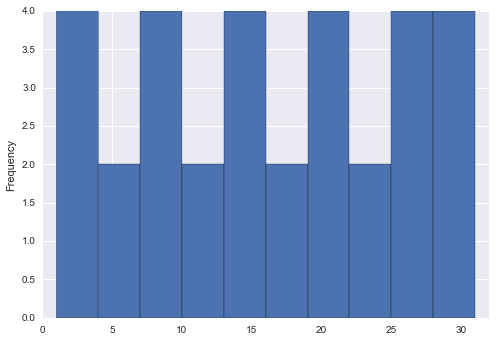

In [4]:
# exercise 4.4.2 
x = range(1, 33)

y = map(lambda x: (2*x + 1) % 32, x)
df = pd.DataFrame({'y':y})
df.plot(kind='hist', xlim=(0,32), legend=False)

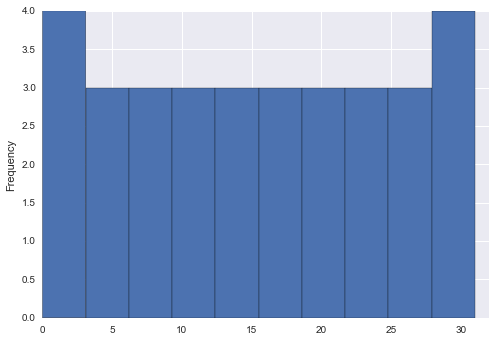

In [5]:
y = map(lambda x: (3*x + 7) % 32, x)
df = pd.DataFrame({'y' : y})
df.plot(kind='hist', xlim=(0,32), legend=False)

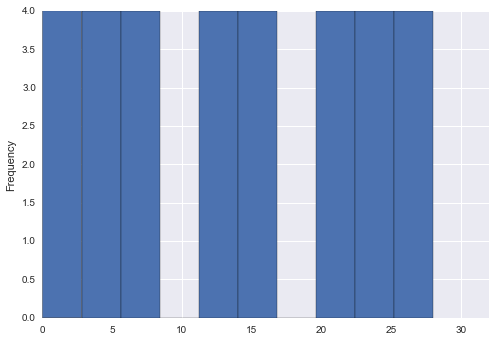

In [6]:
y = map(lambda x: (4*x + 0) % 32, x)
df = pd.DataFrame({'y':y})
df.plot(kind='hist', xlim=(0,32), legend=False)

### 4.5 Estimating Moments

suppose we have a stream $s = e_1 e_2 \dotsm e_n \in {S}^n$.

**kth-order moment** = $\sum_{i \in S} m_i^k$,     
where $m_i$ is the number of occurrences of the $i$-th element in $S$.


Example: 

1. 0th moment: the number of distinct elements, define $0^0 = 0$.

2. 1th moment: the length of the stream.

3. 2nd moment: named the *surprise number*, since it measure how uneven the distribution of elements in the stream is.


#### 4.5.2 The Alon-Matias-Szegedy Algorithm for Second Moments

We compute some number of variables,    
for each variable $X$, we store:  

1. $X.element \in S$.

2. $X.value = 1 + \sum_{i=k+1}^{n} I(e_i = X.element)$    
   where $k = random(1,n)$ and $X.element = e_k$.   
   
   namely, $X.value$ is the times $e_i$ picked randomly occurs in the position among $i, i+1, \dotsc, n$.
   
an **estimate** of the 2nd moment from any variable $X$ is: $$ E_x = n(2 X.value - 1)$$    
2nd moment $\gets Ave_{x \in S} (E_x)$


##### Analysis: Why it works
Let $s = e_1 e_2 \dotsm e_n$, and $e \in S = {S_1, S_2, \dotsc, S_u}$.     
    $c_i$ is the number of times $e_i$ appears among positions $i, i+1, \dotsc, n$.
    
for any picked position $i$,  
\begin{align}
    E[n(2X.value - 1)] &= n(2 E[X.value] - 1) \\
                       &= n(2 \frac{1}{n} \sum_{i=1}^{n} (c_i) - 1) \\
                       &= \sum_{i=1}^{n} (2 c_i - 1) \\
                       &\text{for every $S_j$, existing an arithmetic progression } \sum_a 1+3+ \dotsb + (2m_a -1) \\
                       &= \color{red}{ \sum_{j=1}^{u} \sum_{k=1}^{m_{S_j}} (2k - 1) } \\
                       &= \sum_{j=1}^{u} \frac{m_{S_j}}{2} (1 + (2 m_{S_j} - 1)) \\
                       &= \sum_{j=1}^{u} m^2_{S_j} \quad = \text{ 2nd moment}
\end{align}


##### Higher-Order Moments
for any $k \geq 2$ and $v = X.value$,     
estimate $k$th moments is $$n (v^k - (v-1)^k)$$.

because for given a, $\sum_{v=1}^{m_a} (v^k - (v-1)^k) = m_a^k$.


#### 4.5.5 Dealing With Infinite 
In practice, $n$ is not fixed, but it grows with time.       

+ store variable: $> log_2 n$ bits.    

+ break the condition: every position is picked in **equal probility**.  


**Solution**:   
idea: maintain as many variable $X$ as possible at all times, and to throw some out as the stream grows.

Suppose we have space to store $s$ variables, and we have seen $n$ stream elements.     
hence, the probility of any particular position is picked is $\frac{s}{n}$.

When the $(n+1)$th element arrivs, pick that position with probility $\frac{s}{n+1}$.    
+ if not picked, $s$ remained.    
+ if picked, one of $s$ is ruled out in equal probility, and replaced by the $(n+1)$ position of element $e(n+1)$ with initial value $1$.  


**Analysis**: how the solution correct the probility of any position picked?    

1. for the $(n+1)$th position, the probility of being picked is: $$\frac{s}{n+1}$$

2. for the original $s$ position, the probility of being picked(remained) is: 
$$ \frac{s}{n} (1 - \frac{s}{n+1} \frac{1}{s}) = \frac{s}{n+1} $$



In [ ]:
#todo code

### 4.6 Counting Ones in a Window

**Question**: how many 1's are there in the last $k$ bits of a window with length $N$, for any $k \leq N$.

**solutions**:

1. exact counts: store all $N$ bits at cost.

2. approxicate counts: use $O(lg^2 N)$ bits to represent the window, in the Datar-Gionis-Indyk-Motwani Algorithm.

#### 4.6.2  The Datar-Gionis-Indyk-Motwani Algorithm

##### buckets
we divide the window into buckets.

**construction**
    
1. The timestamp of its right end.
    
2. The number of 1's in the bucket.


**rules**

1. The right end of a bucket is always a position with a 1.

2. Every position with a 1 is in some bucket.

3. No position is in more than one bucket.

4. There are **one or two** buckets of **any given size, up to some maximum size**.     
   namely, suppose the size of the maximum bucket is $2^j$,     
   then, the buckets of the windows should contain all size $2^j, 2^{j-1}, \dotsc, 2^0$, and any size of those should appear either one or two times.

5. All sizes must be a power of 2.

6. Buckets cannot **decrease** in size as we move to the left.

![Fig 4.2](./res/fig_4_2.png)

##### Storage Requirements

1. the maximum size of a bucket is $N$, hence it can be represented by $O(lg N)$ bits.

2. there are at most two buckets for every size from 1 to the maximu size, $2 * j = 2 lg N$，     
   namely, $O(lg N)$ buckets.
   
above all, the total space required for all the buckets representing a window of size $N$ is $O(lg^2 N)$.

##### Query Answering

suppose a window of length $N$ is represented by all buckets $\{b_0, b_1, \dotsc, b_j, \dotsc, b_n\}$, where $b_j$ owns two attributes: timestamp, and size.

for a given $k$, the answer is $$\frac{1}{2} b_j.size + \sum_{i=0}^{j-1} b_i.size \quad \text{for } b_{j+1}\text{.timestamp} > k \geq b_j\text{.timestamp}$$

**error analysis**:      
supposet $c$ is the correct counts. 

there are two cases for estimate:

1. underestimate.    
   + in the worst case, all the 1's of $b_j$ are actually within the query range $k$.     
     $\implies$ the estimate misses half bucket $b_j$, namely, $\frac{1}{2} b_j.size = 2^{j-1}$ 1's.    
   + $c$ is at least $\frac{1 (1 - 2^{j+1})}{1 - 2} = 2^{j+1} - 1$, since there is at least one bucket of each of the size $2^{j-1}, 2^{j-2}, \dotsc, 1$.
   + in all,     
     \begin{align}
         error &= \frac{miss}{c} \\
               &= \frac{2^{j-1}}{2^{j+1} - 1} \\
               &\leq \frac{1}{2}
     \end{align}

2. overestimate.   
   + in the worse case, only the rightmost bit of bucket $b_j$ is within range $k$.   
     $implies$ we overestimate $\frac{b_j.size}{2} - 1 = 2^{j-1} -1$ 1's.    
   + $c$ is at least $1 + 2^j -1 = 2^j$ 1's.    
   + in all,    
     \begin{align}
         error &= \frac{overestimate}{c} \\
               &= \frac{2^{j-1} - 1}{2^j} \\
               &\leq \frac{1}{2}
     \end{align}
   
 
**conclusion**: error is no more than 50% greater than $c$.

##### Maintaining
At $t$ time, a new bit enters:

1. Check the leftmost bucket.      
   if $b_n.timestamp = t - N$, drop it.
   
2. Check the value of the new bit.    
   if it is 0, do nothing;    
   if it is 1, create a new bucket with $t$ and size $1$.      
   + Check if three same size buckets existed,    
     1. if yes, combine the left two adjacent buckets of those, and check the new size bucket again (repeat).      
     2. if no, the round end.      
     
     at most $O(lg N)$ times to check.
     
![fig 4.3](./res/fig_4_3.png)

In [ ]:
#todo code

##### Reducing the Error

idea:    
reduce the error $\gets$ more buckets of **small** sizes $\gets$ relax condition: we allow either $r-1$ or $r$ of each of the exponentially growing sizes for $r > 2$.

combine rules:     
If we get $r+1$ buckets of size $2^j$, combine the leftmost two into a bucket of size $2^{j+1}$.

error analysis:    

1. overestimate.    
   overestimate is $2^{j-1} - 1$.     
   $c$ is at least $1 + (r-1)(2^{j-1} + 2^{j-2} + \dotsb + 1) = 1 + (r-1)(2^j-1)$.     
   the fractional error is $$\frac{2^{j-1} - 1}{1 + (r-1)(2^j - 1)} \leq \frac{1}{r-1}$$
  
2. underestimate.

conclusion: by picking $r$ sufficiently large, we can limit the error to any desired $\epsilon > 0$.

##### Extensions
question: the sum of the last $k$ **integers** for any $1 \leq k \leq N$.

there are two cases:

1. unlikely work out.     
   when the stream contains both positive and negative integers.
   
2. work.    
   when the steam contains only positive integers in the range 1 to $2^m$.     
   solution:     
   + we can treat each of the m bits of each integers as if it were a separate stream.      
   + use the DGIM method to count $c_i$ in $i$th bit stream.     
   + the sum of the integers is: $$\sum_{i=0}^{m-1} c_i 2^i$$

In [8]:
#todo exercise

### 4.7 Decaying Windows

#### exponentially decaying window
Let a steam $= \{a_1, a_2, \dotsc, a_t\}$,      
we define the exponentially decaying window for this stream to be the sum: $$\sum_{i=0}^{t-1} a_{t-i} (1-c)^i$$

![fig 4.4](./res/fig_4_4.png)

maintain:    
when a new element $a_{t+1}$ arrives, all we need to do is:

1. Multiply the current sum by $1-c$.

2. Add $a_{t+}$.

#### Finding the Most Popular Elements

When a new ticket arrives on the stream, do the following:

1. For each movie, multiply its score by $(1-c)$.

2. Suppose the new ticket is for movie $M$.     
   1. if a score for $M$ existed, add 1.    
   2. if not, create one and initialize it to 1.
   
3. If any score is below the threshold $1/2$, drop that score.


analysis:

Note that the sum of all scores is $1/c$,     
there cannot be more than $2/c$ moview with score of $1/2$ or more. $\gets$ $1/c = 1/2 \times 2/c$.

hence, $2/c$ is a limit on the number of movies being counted at any time.